In [2]:
import awkward as ak
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.regularizers import l1
from keras_tuner.tuners import RandomSearch
import os, datetime
from sklearn.utils.class_weight import compute_class_weight
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.metrics import AUC
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import F1Score
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from keras.callbacks import LearningRateScheduler

# list_of_files = glob.glob('/path/to/folder/*') # * means all if need specific format then *.csv
# latest_file = max(list_of_files, key=os.path.getctime)

inpath = "/home/elias/taubus/unsorted_smallnet_outputs_for_training_2024_08_30-12_45_05_PM/"
X_train = ak.to_numpy(ak.from_parquet(inpath +"X_train_scaled.parquet")  )
y_train = ak.to_numpy(ak.from_parquet(inpath +"y_train_scaled.parquet"))
X_test =  ak.to_numpy(ak.from_parquet(inpath +"X_test_scaled.parquet"))
y_test = ak.to_numpy(ak.from_parquet(inpath +"y_test_scaled.parquet"))
print(type(y_train[0]))
print(type(y_test[0]))
unique, counts = np.unique([y_train], return_counts=True)
print(counts)

unique, counts = np.unique([y_test], return_counts=True)
print(counts)




<class 'numpy.float64'>
<class 'numpy.float64'>
[151291  52664]
[100538  35432]


In [3]:

# Define the model-building function
def build_model(hp):
    model = Sequential()
    
    # First Dense Layer
    model.add(Dense(
        units=hp.Int('units_fc1', min_value=128, max_value=512, step=64),
        input_shape=(X_train.shape[1],),
        name='fc1',
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(hp.Float('reg1', 0.0001, 0.001, step=0.0001)),
        bias_regularizer=l1(hp.Float('regb1', 0.0001, 0.001, step=0.0001)),

    ))
    model.add(Activation(activation='relu', name='relu1'))
    model.add(Dropout(hp.Float('dropout_fc1', 0.1, 0.3, step=0.1)))
    
    # Second Dense Layer
    model.add(Dense(
        units=hp.Int('units_fc2', min_value=32, max_value=512, step=32),
        name='fc2',
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(hp.Float('reg2', 0.0001, 0.001, step=0.0001)),
        bias_regularizer=l1(hp.Float('regb2', 0.0001, 0.001, step=0.0001)),

    ))
    model.add(Activation(activation='relu', name='relu2'))
    model.add(Dropout(hp.Float('dropout_fc2', 0.1, 0.3, step=0.1)))
    
    # Third Dense Layer
    model.add(Dense(
        units=hp.Int('units_fc3', min_value=16, max_value=512, step=64),
        name='fc3',
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(hp.Float('reg3', 0.0001, 0.001, step=0.0001)),
        bias_regularizer=l1(hp.Float('regb3', 0.0001, 0.001, step=0.0001)),

    ))
    model.add(Activation(activation='relu', name='relu3'))
    model.add(Dropout(hp.Float('dropout_fc3', 0.1, 0.3, step=0.1)))

    #     # Third Dense Layer
    # model.add(Dense(
    #     units=hp.Int('units_fc4', min_value=16, max_value=512, step=32),
    #     name='fc4',
    #     kernel_initializer='lecun_uniform',
    #     kernel_regularizer=l1(hp.Float('reg4', 0.0001, 0.004, step=0.0001)),
    #     bias_regularizer=l1(hp.Float('regb4', 0.0001, 0.001, step=0.0001))

    # ))
    # model.add(Activation(activation='relu', name='relu4'))
    # model.add(Dropout(hp.Float('dropout_fc4', 0.1, 0.5, step=0.1)))


    # model.add(Dense(
    #     units=hp.Int('units_fc5', min_value=16, max_value=512, step=32),
    #     name='fc5',
    #     kernel_initializer='lecun_uniform',
    #     kernel_regularizer=l1(hp.Float('reg5', 0.0001, 0.004, step=0.0001)),
    #     bias_regularizer=l1(hp.Float('regb5', 0.0001, 0.001, step=0.0001))

    # ))
    # model.add(Activation(activation='relu', name='relu5'))
    # model.add(Dropout(hp.Float('dropout_fc5', 0.1, 0.5, step=0.1)))

    
    # Output Layer
    model.add(Dense(1, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
    model.add(Activation(activation='sigmoid', name='sigmoid'))
    
    hp_learning_rate = hp.Choice('learning_rate', 
                                 values=[1e-2, 1e-3, 1e-4]
                                 )
    optimizers_dict = {
        "Adam":    Adam(learning_rate=hp_learning_rate),
        "SGD":     SGD(learning_rate=hp_learning_rate),
        "Adagrad": Adagrad(learning_rate=hp_learning_rate)
        }

    hp_optimizers = hp.Choice(
        'optimizer', 
        values=["Adam"]
        )

    model.compile(
        optimizer=optimizers_dict[hp_optimizers],
        loss=['binary_crossentropy'], metrics=['accuracy']
        )
    return model


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.regularizers import l1
from keras_tuner.tuners import RandomSearch,Hyperband,BayesianOptimization
import os, datetime
from sklearn.utils.class_weight import compute_class_weight

#weighing trues and false
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)

# Convert class_weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)
# {0: 0.6760281873143827, 1: 1.9202270887077033}



{0: 0.6740486876284776, 1: 1.9363796901108916}


In [6]:

tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs = 30,
    factor=3,
    hyperband_iterations=2,
    seed=None,
    hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True,
    # overwrite=False,
    directory='summer2024_unsorted_corrected_inputs_hyperband_smallnet_v4',
    project_name='forethesis4',

)



In [7]:

# Load your dataset here
# X_train, y_train, X_val, y_val = ...

# Define the search space for algorithm parameters
outdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(outdir, histogram_freq=1)
print(outdir)


logs/20240830-124656


In [8]:
# Run the hyperparameter search
tuner.search(X_train, y_train, validation_data=(X_test, y_test), 
                 class_weight=class_weight_dict,
    
    batch_size=256,shuffle= True,
             callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),tensorboard_callback
])
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

Trial 180 Complete [00h 02m 31s]
val_accuracy: 0.6947120428085327

Best val_accuracy So Far: 0.7370155453681946
Total elapsed time: 01h 21m 58s


In [6]:

# Retrieve and print the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units_fc1')}, the second layer is {best_hps.get('units_fc2')}, 
the third layer is {best_hps.get('units_fc3')}, 
the optimal dropout rate for the first layer is {best_hps.get('dropout_fc1')},
the second layer is {best_hps.get('dropout_fc2')},

""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 448, the second layer is 384, 
the third layer is 144, 
the optimal dropout rate for the first layer is 0.1,
the second layer is 0.1,




In [8]:
# best_hps = tuner.get_best_hyperparameters()[0]


In [9]:
# tuner = Hyperband(
#     build_model,
#     objective='val_accuracy',
#     max_epochs = 30,
#     factor=3,
#     hyperband_iterations=1,
#     seed=None,
#     hyperparameters=None,
#     tune_new_entries=True,
#     allow_new_entries=True,
#     overwrite=False,
#     directory='summer2024_hyperband_bger_net_trial',
#     project_name='forethesis2',

# )
# best_hps = tuner.get_best_hyperparameters()[0]


In [10]:

# print(f"""
# The hyperparameter search is complete. The optimal number of units in the first densely-connected
# layer is {best_hps.get('units_fc1')}, the second layer is {best_hps.get('units_fc2')}, 
# the third layer is {best_hps.get('units_fc3')}, 
# the optimal dropout rate for the first layer is {best_hps.get('dropout_fc1')},
# the second layer is {best_hps.get('dropout_fc2')},
# the best optimizer is {best_hps.get('optimizer')},
# and the best learning rate is {best_hps.get('learning_rate')}.
# """)

In [8]:

model = tuner.get_best_models()[0]
# model.save(filepath=outdir+"model_best.keras")
# model.summary()
# print(class_weight_dict)
# print(best_hps.get('learning_rate'))

In [12]:
from keras.models import load_model
# model = load_model("/home/elias/taubus/logs/20240729-120116model")
import keras.metrics

import cosan

d = cosan.Cosine_annealing()
d.lr_max_warmup = 0.0005
d.lr_max = 0.0005
d.lr_min = 0.0001
d.multiplier = 2
d.riseepochs = 5
d.warmup_epochs = 5
d.cyclelength = 10

e = cosan.Cosine_annealing()
e.lr_max_warmup = 0.0005
e.lr_max = 0.0005
e.lr_min = 0.00009
e.multiplier = 2
e.riseepochs = 5
e.warmup_epochs = 40
e.cyclelength = 100

d.ampmod = True
lr_scheduler = LearningRateScheduler(d.cosine_annealing_schedule)
lr_scheduler2 = LearningRateScheduler(e.cosine_annealing_schedule)


model_cloned_1 = tf.keras.models.clone_model(model)
model_cloned_1.compile(
        optimizer=Adam(learning_rate=1e-4),

        loss=['binary_crossentropy'], metrics=['accuracy',
        keras.metrics.BinaryAccuracy(),
        keras.metrics.FalseNegatives(),
    ],

        )



In [13]:


lr_scheduler = LearningRateScheduler(d.cosine_annealing_schedule)
%time
history1 = model_cloned_1.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=512,
    epochs=640,
    class_weight=class_weight_dict,
    # validation_split=0.2,
    shuffle=True,
    callbacks=[tensorboard_callback],
)


model_cloned_2 = tf.keras.models.clone_model(model)
model_cloned_2.compile(
        optimizer=Adam(learning_rate=1e-3),

        loss=['binary_crossentropy'], metrics=['accuracy',
        keras.metrics.BinaryAccuracy(),
        keras.metrics.FalseNegatives(),
    ],

        )
model_cloned_3 = tf.keras.models.clone_model(model)
model_cloned_3.compile(
        optimizer=Adam(learning_rate=1e-3),

        loss=['binary_crossentropy'], metrics=['accuracy',
        keras.metrics.BinaryAccuracy(),
        keras.metrics.FalseNegatives(),
    ],

        )




lr_scheduler = LearningRateScheduler(d.cosine_annealing_schedule)
%time
history2 = model_cloned_2.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=512,
    epochs=640,
    class_weight=class_weight_dict,
    # validation_split=0.2,
    shuffle=True,
    callbacks=[tensorboard_callback,lr_scheduler],
)
history3 = model_cloned_3.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=512,
    epochs=640,
    class_weight=class_weight_dict,
    # validation_split=0.2,
    shuffle=True,
    callbacks=[tensorboard_callback,lr_scheduler2],
)


CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 7.15 µs
Epoch 1/640
399/399 [==============================] - 5s 10ms/step - loss: 3.7304 - accuracy: 0.6148 - binary_accuracy: 0.6148 - false_negatives_1: 21270.0000 - val_loss: 2.8051 - val_accuracy: 0.6727 - val_binary_accuracy: 0.6727 - val_false_negatives_1: 11602.0000
Epoch 2/640
399/399 [==============================] - 4s 11ms/step - loss: 2.1688 - accuracy: 0.6734 - binary_accuracy: 0.6734 - false_negatives_1: 15351.0000 - val_loss: 1.6531 - val_accuracy: 0.6752 - val_binary_accuracy: 0.6752 - val_false_negatives_1: 7911.0000
Epoch 3/640
399/399 [==============================] - 6s 16ms/step - loss: 1.3703 - accuracy: 0.6888 - binary_accuracy: 0.6888 - false_negatives_1: 13289.0000 - val_loss: 1.1828 - val_accuracy: 0.6833 - val_binary_accuracy: 0.6833 - val_false_negatives_1: 7341.0000
Epoch 4/640
399/399 [==============================] - 6s 16ms/step - loss: 1.0703 - accuracy: 0.7015 - binary_accuracy: 0.7015 - fals

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 6))
history2 = history2
plt.subplot(1, 2, 1)
sns.lineplot(x=range(1, len(history1.history['accuracy']) + 1), y=history1.history['accuracy'], label='Train Accuracy Lr=0.0001')
sns.lineplot(x=range(1, len(history2.history['accuracy']) + 1), y=history2.history['accuracy'], label='Train Accuracy Learning Rate schedule 1')
sns.lineplot(x=range(1, len(history3.history['accuracy']) + 1), y=history3.history['accuracy'], label='Train Accuracy Learning Rate schedule 2')
sns.lineplot(x=range(1, len(history1.history['val_accuracy']) + 1), y=history1.history['val_accuracy'], label='Validation Accuracy Lr=0.0001')
sns.lineplot(x=range(1, len(history2.history['val_accuracy']) + 1), y=history2.history['val_accuracy'], label='Validation Accuracy Learning Rate schedule ')
sns.lineplot(x=range(1, len(history3.history['val_accuracy']) + 1), y=history3.history['val_accuracy'], label='Validation Accuracy Learning Rate schedule 2')

plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
sns.lineplot(x=range(1, len(history1.history['loss']) + 1), y=history1.history['loss'], label='Train Loss Lr=0.0001')
sns.lineplot(x=range(1, len(history1.history['val_loss']) + 1), y=history1.history['val_loss'], label='Validation Loss Lr=0.0001')
sns.lineplot(x=range(1, len(history2.history['loss']) + 1), y=history2.history['loss'], label='Train Loss Learning Rate schedule ')
sns.lineplot(x=range(1, len(history2.history['val_loss']) + 1), y=history2.history['val_loss'], label='Validation LossLearning Rate schedule ')
sns.lineplot(x=range(1, len(history3.history['loss']) + 1), y=history3.history['loss'], label='Train Loss Learning Rate schedule 2')
sns.lineplot(x=range(1, len(history3.history['val_loss']) + 1), y=history3.history['val_loss'], label='Validation Loss Learning Rate schedule 2')

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

NameError: name 'history2' is not defined

<Figure size 1200x600 with 0 Axes>

In [15]:
model_cloned_4 = tf.keras.models.clone_model(model)
model_cloned_4.compile(
        optimizer=Adam(learning_rate=1e-3),

        loss=['binary_crossentropy'], metrics=['accuracy',
        keras.metrics.BinaryAccuracy(),
        keras.metrics.FalseNegatives(),
    ],

        )
model_cloned_5 = tf.keras.models.clone_model(model)
model_cloned_5.compile(
        optimizer=Adam(learning_rate=1e-3),

        loss=['binary_crossentropy'], metrics=['accuracy',
        keras.metrics.BinaryAccuracy(),
        keras.metrics.FalseNegatives(),
    ],

        )




lr_scheduler = LearningRateScheduler(d.cosine_annealing_schedule)
%time
history4 = model_cloned_4.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=64,
    epochs=640,
    class_weight=class_weight_dict,
    # validation_split=0.2,
    shuffle=True,
    callbacks=[tensorboard_callback,lr_scheduler],
)
history5 = model_cloned_5.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=64,
    epochs=640,
    class_weight=class_weight_dict,
    # validation_split=0.2,
    shuffle=True,
    callbacks=[tensorboard_callback,lr_scheduler2],
)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs
epoch 0
Epoch 1/640
3187/3187 [==============================] - 17s 5ms/step - loss: 2.1803 - accuracy: 0.6615 - binary_accuracy: 0.6615 - false_negatives_4: 16320.0000 - val_loss: 1.0909 - val_accuracy: 0.7216 - val_binary_accuracy: 0.7216 - val_false_negatives_4: 9787.0000 - lr: 1.0000e-04
epoch 1
Epoch 2/640
3187/3187 [==============================] - 16s 5ms/step - loss: 0.8294 - accuracy: 0.7126 - binary_accuracy: 0.7126 - false_negatives_4: 12603.0000 - val_loss: 0.6758 - val_accuracy: 0.7420 - val_binary_accuracy: 0.7420 - val_false_negatives_4: 8658.0000 - lr: 2.3820e-04
epoch 2
Epoch 3/640
3187/3187 [==============================] - 16s 5ms/step - loss: 0.6356 - accuracy: 0.7309 - binary_accuracy: 0.7309 - false_negatives_4: 12305.0000 - val_loss: 0.5836 - val_accuracy: 0.7440 - val_binary_accuracy: 0.7440 - val_false_negatives_4: 8398.0000 - lr: 4.6180e-04
epoch 3
Epoch 4/640
3187/3187 [=======================

In [16]:
numbers = history1.history['val_loss']
min_value = min(numbers)
min_index = numbers.index(min_value)

print("Minimum  lrs const value:", min_value)
print("Index of minimum value:", min_index)


numbers = history1.history['val_accuracy']
min_value = max(numbers)
min_index = numbers.index(min_value)

print("Max acc lrs const value:", min_value)
print("Index of minimum value:", min_index)

numbers = history3.history['val_loss']
min_value = min(numbers)
min_index = numbers.index(min_value)

print("Minimum lrs2 value:", min_value)
print("Index of minimum value:", min_index)


numbers = history3.history['val_accuracy']
min_value = max(numbers)
min_index = numbers.index(min_value)

print("max acc lrs2 value:", min_value)
print("Index of minimum value:", min_index)

numbers = history2.history['val_accuracy']
min_value = max(numbers)
min_index = numbers.index(min_value)
print("max acc lrs1 value:", min_value)
print("Index of minimum value:", min_index)


numbers = history2.history['val_loss']
min_value = min(numbers)
min_index = numbers.index(min_value)

print("Minimum lrs1 value:", min_value)
print("Index of minimum value:", min_index)


Minimum  lrs const value: 0.48733067512512207
Index of minimum value: 230
Max acc lrs const value: 0.8101640343666077
Index of minimum value: 438
Minimum lrs2 value: 0.4755825698375702
Index of minimum value: 249
max acc lrs2 value: 0.812076210975647
Index of minimum value: 249
max acc lrs1 value: 0.8071339130401611
Index of minimum value: 383
Minimum lrs1 value: 0.47766852378845215
Index of minimum value: 362


epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
epoch 51
epoch 52
epoch 53
epoch 54
epoch 55
epoch 56
epoch 57
epoch 58
epoch 59
epoch 60
epoch 61
epoch 62
epoch 63
epoch 64
epoch 65
epoch 66
epoch 67
epoch 68
epoch 69
epoch 70
epoch 71
epoch 72
epoch 73
epoch 74
epoch 75
epoch 76
epoch 77
epoch 78
epoch 79
epoch 80
epoch 81
epoch 82
epoch 83
epoch 84
epoch 85
epoch 86
epoch 87
epoch 88
epoch 89
epoch 90
epoch 91
epoch 92
epoch 93
epoch 94
epoch 95
epoch 96
epoch 97
epoch 98
epoch 99
epoch 100
epoch 101
epoch 102
epoch 103
epoch 104
epoch 105
epoch 106
epoch 107
epoch 108
epoch 109
epoch 110


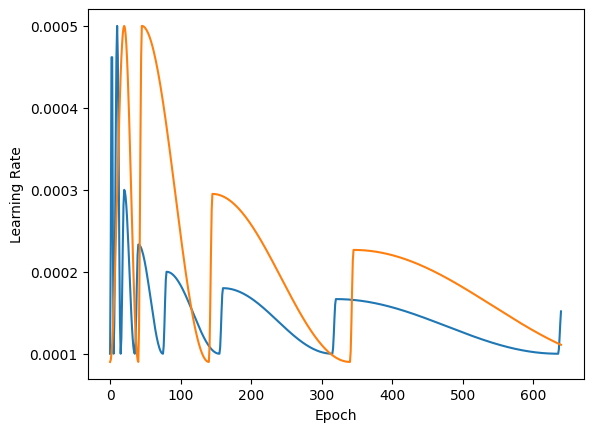

In [17]:
xx = [d.cosine_annealing_schedule(i) for i in range(640)]
yy = [e.cosine_annealing_schedule(i) for i in range(640)]
plt.plot(xx,label="Learning Rate Schedule 1")
plt.plot(yy,label="Learning Rate Schedule 2")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.show()

4250/4250 [==============================] - 4s 863us/step


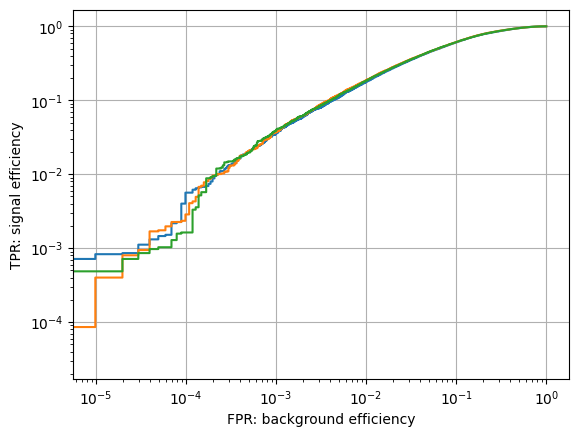

In [18]:
y_test_pred1 = model_cloned_1.predict(X_test)
y_test_pred3 = model_cloned_3.predict(X_test)
y_test_pred2 = model_cloned_2.predict(X_test)

from sklearn.metrics import roc_curve

fpr1, tpr1, thr1 = roc_curve(y_test, y_test_pred1, drop_intermediate=False)
fpr3, tpr3, thr3 = roc_curve(y_test, y_test_pred3, drop_intermediate=False)
fpr2, tpr2, thr2 = roc_curve(y_test, y_test_pred2, drop_intermediate=False)

plt.plot(fpr1, tpr1)
plt.plot(fpr3, tpr3)

plt.plot(fpr2, tpr2)
plt.loglog()
plt.xlabel("FPR: background efficiency")
plt.ylabel("TPR: signal efficiency")
plt.grid()


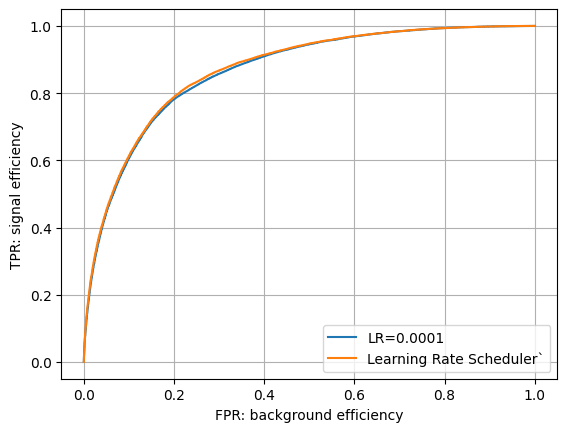

In [19]:
plt.plot(fpr1, tpr1, label = "LR=0.0001")
plt.plot(fpr3, tpr3, label = "Learning Rate Scheduler`")

plt.xlabel("FPR: background efficiency")
plt.ylabel("TPR: signal efficiency")
plt.legend()
plt.grid()





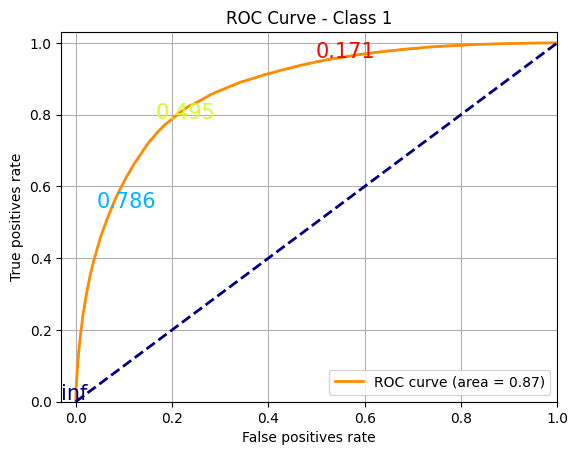

In [28]:
import sklearn # for the roc curve
import matplotlib.pyplot as plt

def plot_roc(labels, predictions, positive_label, thresholds_every=10, title=''):
  # fp: false positive rates. tp: true positive rates
  fp, tp, thresholds = sklearn.metrics.roc_curve(labels, predictions, pos_label=positive_label)
  roc_auc = sklearn.metrics.auc(fp, tp)

  # figure(figsize=(16, 16))
  plt.plot(fp, tp, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=2, color='darkorange')
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--', linewidth=2)
  plt.xlabel('False positives rate')
  plt.ylabel('True positives rate')
  plt.xlim([-0.03, 1.0])
  plt.ylim([0.0, 1.03])
  plt.title(title)
  plt.legend(loc="lower right")
  plt.grid(True)

  # plot some thresholds
  thresholdsLength = len(thresholds)
  colorMap=plt.get_cmap('jet', thresholdsLength)
  for i in range(0, thresholdsLength, thresholds_every):
    threshold_value_with_max_four_decimals = str(thresholds[i])[:5]
    plt.text(fp[i] - 0.03, tp[i] + 0.005, threshold_value_with_max_four_decimals, fontdict={'size': 15}, color=colorMap(i/thresholdsLength));
  plt.show()


plot_roc(y_test, y_test_pred3, positive_label=1, thresholds_every=10000, title="ROC Curve - Class 1")

/tmp/ipykernel_1299922/3108597816.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')
/tmp/ipykernel_1299922/3108597816.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


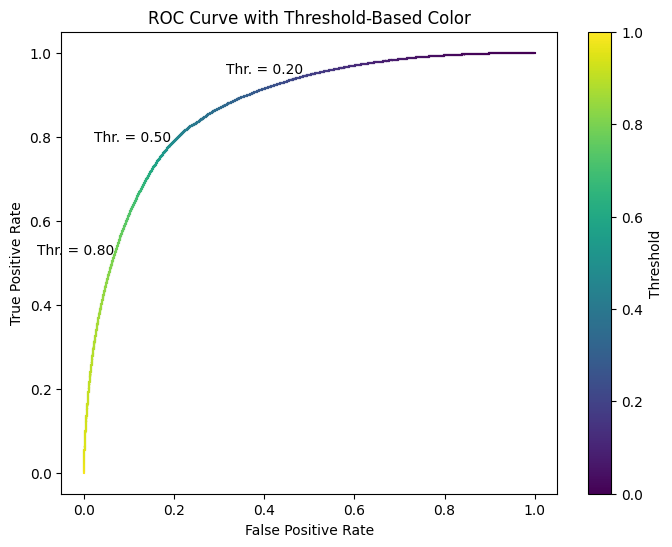

In [37]:
# Normalize thresholds for colormap


import matplotlib.cm as cm
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred3, drop_intermediate=False)

# norm_thresholds = (thresholds - thresholds.min()) / (thresholds.max() - thresholds.min())

# Create a color map
cmap = cm.get_cmap('viridis')

# Plot the ROC curve with varying colors
plt.figure(figsize=(8, 6))
for i in range(len(fpr) - 1):
    plt.plot(fpr[i:i+2], tpr[i:i+2], color=cmap(thresholds[i]))

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Threshold')

# Annotate some threshold values on the curve
threshold_points = [0.2, 0.5, 0.8]
for t in threshold_points:
    idx = np.argmin(np.abs(thresholds - t))
    plt.text(fpr[idx], tpr[idx], f'Thr. = {t:.2f}', 
             verticalalignment='bottom', horizontalalignment='right', color='black', fontsize=10)

# Plot labels and show the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Threshold-Based Color')
plt.show()

In [35]:
print(thresholds[-2])

1.418485e-13


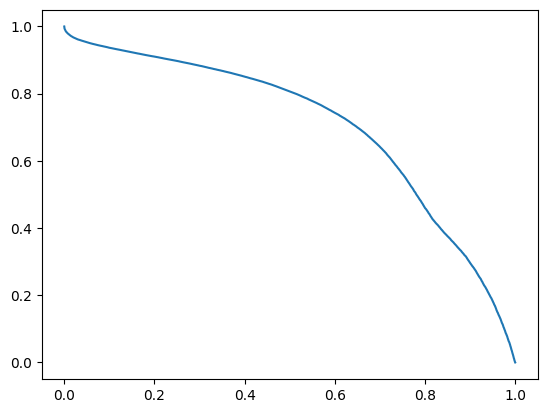

In [26]:
plt.plot(tpr3, thr3, label = "Learning Rate Scheduler`")


In [20]:
# lr_scheduler = LearningRateScheduler(cosine_annealing_schedule)
%time
history10 = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=500,
    class_weight=class_weight_dict,
    validation_split=0.2,
    shuffle=True,
    callbacks= tensorboard_callback,
)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs
Epoch 1/500
6374/6374 [==============================] - 22s 3ms/step - loss: 0.5956 - accuracy: 0.7383 - val_loss: 0.5536 - val_accuracy: 0.7654
Epoch 2/500
6374/6374 [==============================] - 21s 3ms/step - loss: 0.5874 - accuracy: 0.7441 - val_loss: 0.5612 - val_accuracy: 0.7586
Epoch 3/500
6374/6374 [==============================] - 21s 3ms/step - loss: 0.5795 - accuracy: 0.7471 - val_loss: 0.5421 - val_accuracy: 0.7769
Epoch 4/500
6374/6374 [==============================] - 21s 3ms/step - loss: 0.5803 - accuracy: 0.7479 - val_loss: 0.5949 - val_accuracy: 0.7374
Epoch 5/500
6374/6374 [==============================] - 21s 3ms/step - loss: 0.5793 - accuracy: 0.7497 - val_loss: 0.5753 - val_accuracy: 0.7594
Epoch 6/500
6374/6374 [==============================] - 21s 3ms/step - loss: 0.5786 - accuracy: 0.7510 - val_loss: 0.5663 - val_accuracy: 0.7602
Epoch 7/500
6374/6374 [==============================] - 21s

In [24]:
import os
from datetime import datetime
# from tensorflow.keras.models import Sequential



models = [model_cloned_1,model_cloned_2,model_cloned_3,model_cloned_4,model_cloned_5]
model_names = ["lrconst.keras","lrs1.keras","lrs2.keras","lrs1smallbatch.keras","lrs2smallbatch.keras",]
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
save_dir = f'models_{timestamp}'
# Create the directory
os.makedirs(save_dir, exist_ok=True)

# Save each model in the directory
for i, model in enumerate(models):
    model_path = os.path.join(save_dir, model_names[i])
    model.save(model_path)
    print(f"Saved {model_names[i]} at {model_path}")

#     Cosine annealing schedule.


Saved lrconst.keras at models_20240817_124429/lrconst.keras
Saved lrs1.keras at models_20240817_124429/lrs1.keras
Saved lrs2.keras at models_20240817_124429/lrs2.keras
Saved lrs1smallbatch.keras at models_20240817_124429/lrs1smallbatch.keras
Saved lrs2smallbatch.keras at models_20240817_124429/lrs2smallbatch.keras


In [ ]:
    
#     Parameters:
#     - epoch: int, the current epoch number.
#     - lr: float, the current learning rate.
    
#     Returns:
#     - new_lr: float, the updated learning rate.
#     """
#     initial_lr = 0.01
#     min_lr = 0.0001
#     total_epochs = 1000

#     cosine_decay = 0.5 * (1 + np.cos(np.pi * epoch / total_epochs))
#     new_lr = min_lr + (initial_lr - min_lr) * cosine_decay
#     return float(new_lr)

# # Create the LearningRateScheduler callback
# lr_scheduler = LearningRateScheduler(cosine_annealing_schedule)
# %time
# history = model.fit(
#     X_train,
#     y_train,
#     batch_size=256,
#     epochs=1000,
#     class_weight=class_weight_dict,
#     validation_split=0.2,
#     shuffle=True,
#     callbacks=[tensorboard_callback,lr_scheduler],
# )
# lr_scheduler = LearningRateScheduler(d.cosine_annealing_schedule)
%time

d = cosan.Cosine_annealing()
d.lr_max_warmup = 0.005
d.lr_max = 0.0005
d.lr_min = 0.0001
d.multiplier = 2
d.ampmod = True
lr_scheduler = LearningRateScheduler(d.cosine_annealing_schedule)
d.warmup_epochs = 10
history4 = model_cloned_2.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=1250,
    class_weight=class_weight_dict,
    validation_split=0.2,
    shuffle=True,
    callbacks=[tensorboard_callback,lr_scheduler],
)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 512)               184832    
                                                                 
 relu1 (Activation)          (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 fc2 (Dense)                 (None, 32)                16416     
                                                                 
 relu2 (Activation)          (None, 32)                0         
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 fc3 (Dense)                 (None, 48)                1

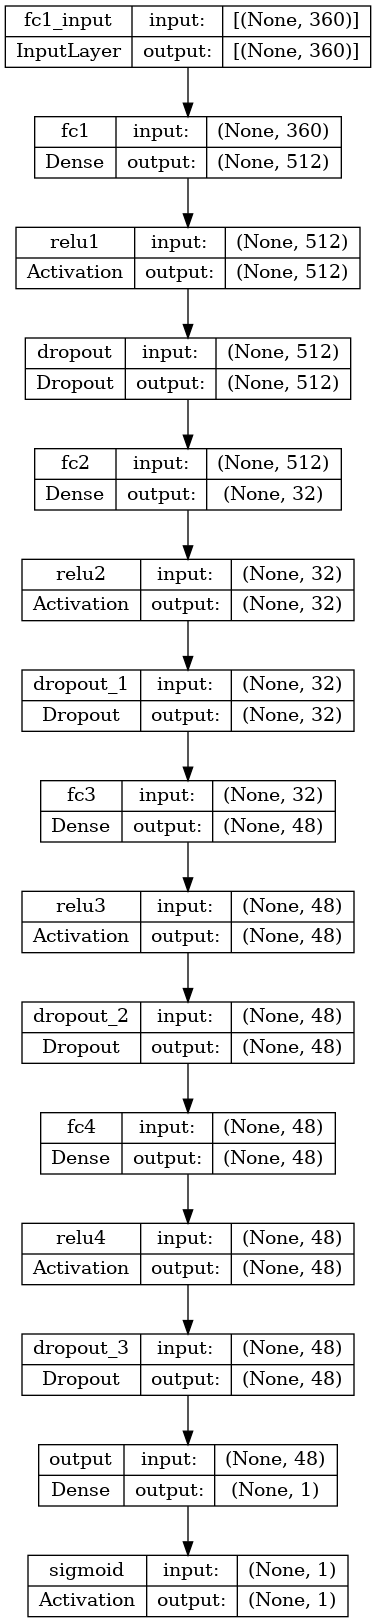

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


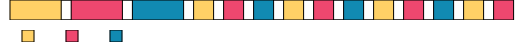

In [ ]:
import visualkeras
visualkeras.layered_view(model, legend=True, draw_volume=False)

In [ ]:

history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=1000,
    class_weight=class_weight_dict,
    validation_split=0.2,
    shuffle=True,
    callbacks=[tensorboard_callback,lr_scheduler],
)

In [ ]:
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    class_weight=class_weight_dict,
    validation_split=0.2,
    shuffle=True,
    
    callbacks=tensorboard_callback,
)

In [ ]:
model = tuner.hypermodel.build(best_hps)
# history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)
tensorboard_callback = tf.keras.callbacks.TensorBoard(outdir, histogram_freq=1)
print(outdir)


/home/elias/taubus/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


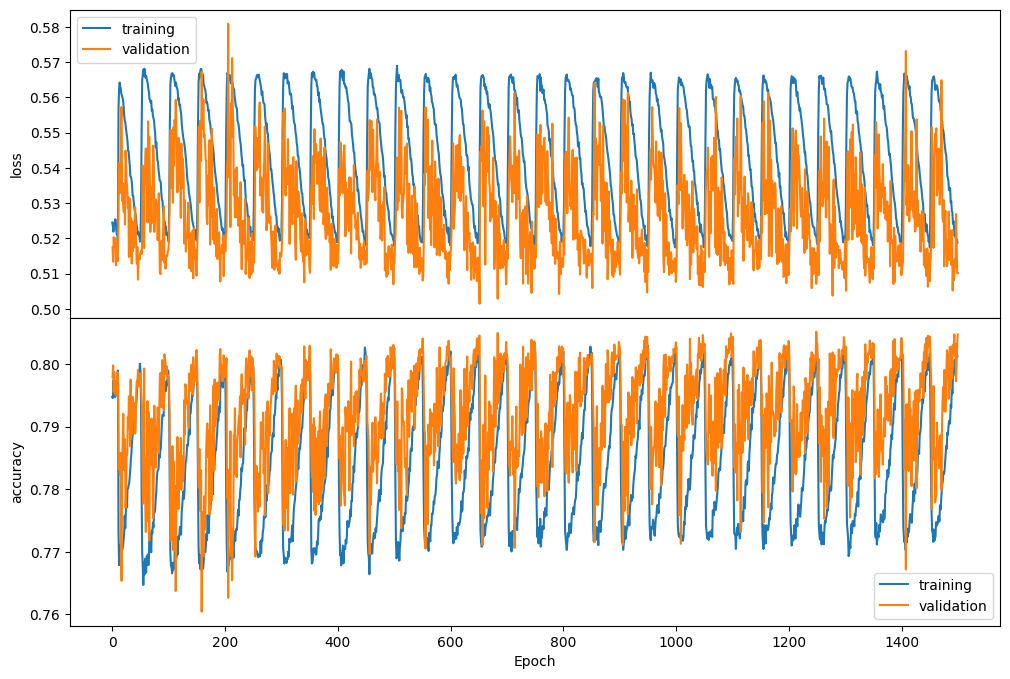

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pickle
def plotTrainingHistory(history, metrics = ["loss", "accuracy"], f = None, axs = None):

    # creating the plot
    if not f and not axs: 
        f, axs = plt.subplots(len(metrics), 1, figsize = (12, 4*len(metrics)), sharex = True)
    if len(metrics) == 1:
        axs = [axs]
    plt.subplots_adjust(wspace=0, hspace=0)

    # labeling
#     hep.cms.label("private work", data=False, ax=axs[0])

    for i in range(len(metrics)):
        
        metric = metrics[i]
        ax = axs[i]
        ax.set_ylabel(metric)
        
        if isinstance(history, list): # handle kfold
            for foldi in range(len(history)):
                ax.plot(history[foldi].history[metric], color = "C{}".format(foldi))
                ax.plot(history[foldi].history['val_' + metric], color = "C{}".format(foldi), linestyle = "--")
                
            la2, = ax.plot([0,0], [0,0], color="Grey")
            lb2, = ax.plot([0,0], [0,0], color="Grey", linestyle = "--")
            ax.legend([la2, lb2], ["training", "validation"])
        else: 
            xs = np.arange(len(history.history['val_' + metric]))
            ax.plot(xs,history.history[metric], label = 'training')
            ax.plot(xs+.5, history.history['val_' + metric], label= 'validation')
            ax.legend()

    axs[-1].set_xlabel("Epoch")
    
    return f, axs


model.save(outdir + "/model.h5")

with open(outdir + "/history.pkl", 'wb') as file_pi: pickle.dump(history, file_pi)

fig = plotTrainingHistory(history)



In [ ]:
y_test_pred = model.predict(X_test)  # Save predictions:
ak.to_parquet(y_test_pred, outdir+"y_test_pred.parquet")  
from sklearn.metrics import roc_curve

fpr, tpr, thr = roc_curve(y_test, y_test_pred, drop_intermediate=False)

def totalMinBiasRate(nCollBunch = 2500):
    LHCfreq = 11245.6
    return LHCfreq * nCollBunch / 1e3 # in kHz


plt.plot(fpr * totalMinBiasRate(), tpr)
plt.xlabel("FPR*MBrate: Trigger rate [kHz]")
plt.ylabel("TPR: signal efficiency")
plt.grid()
plt.xlim(0,1000)

In [ ]:
%time
y_test_pred = model.predict(X_test)  # Save predictions:
ak.to_parquet(y_test_pred, outdir+"y_test_pred.parquet")  

from sklearn.metrics import roc_curve

fpr, tpr, thr = roc_curve(y_test, y_test_pred, drop_intermediate=False)  
plt.plot(fpr, tpr)
plt.xlabel("FPR: background efficiency")
plt.ylabel("TPR: signal efficiency")
plt.xscale('log')
plt.grid()
plt.savefig(outdir+'efficiency.png')

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thr = roc_curve(y_test, y_test_pred, drop_intermediate=False)  
plt.plot(fpr, tpr)
plt.xlabel("FPR: background efficiency")
plt.ylabel("TPR: signal efficiency")
# plt.xscale('log')
plt.grid()
plt.savefig(outdir+'efficiency.png')